<a href="https://colab.research.google.com/github/natrask/ENM1050/blob/main/Code%20examples/lotkaFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

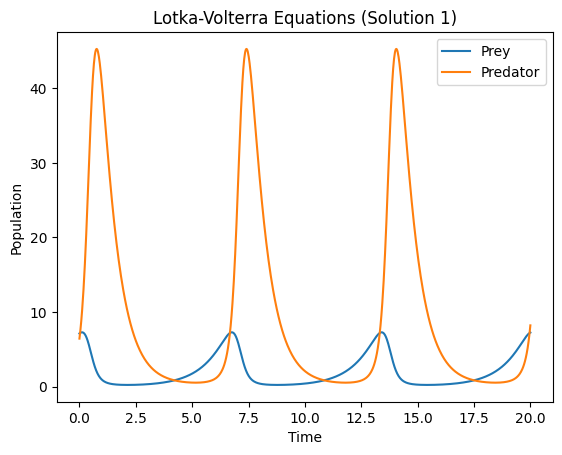

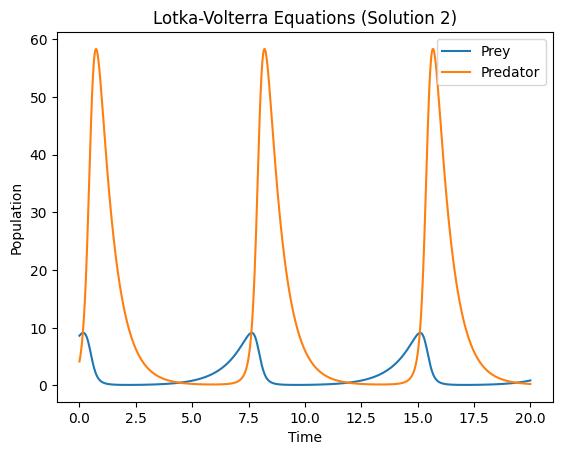

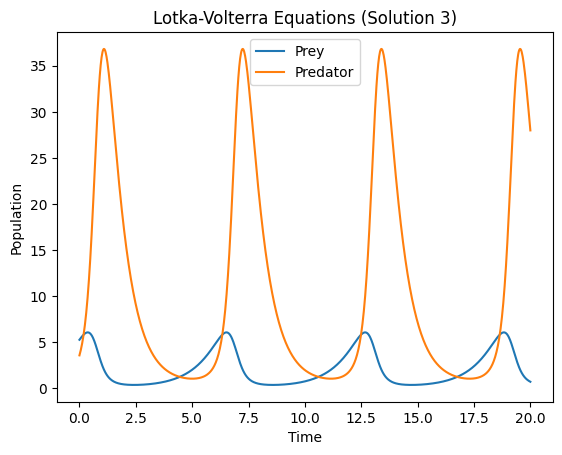

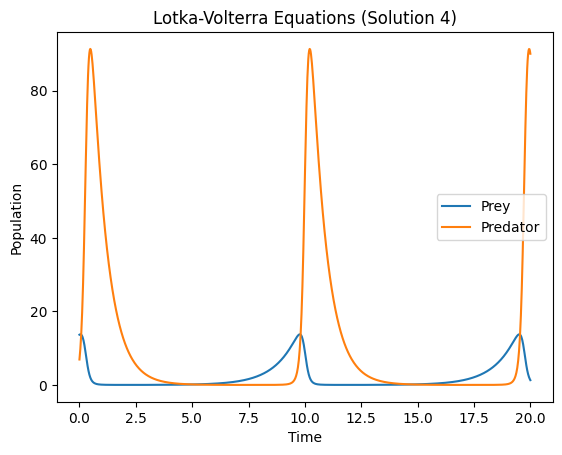

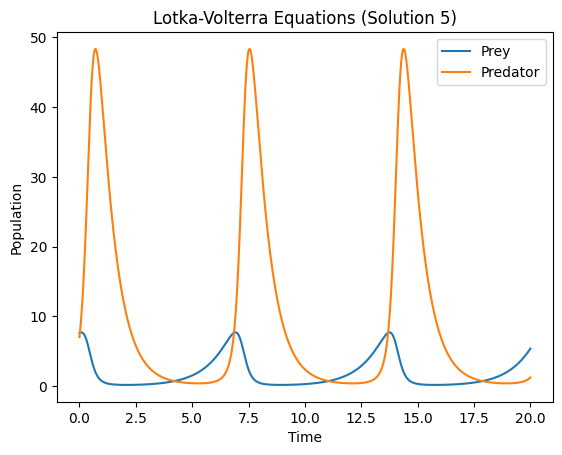

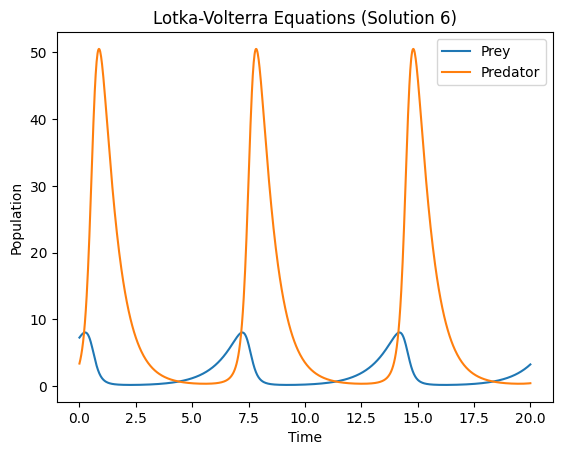

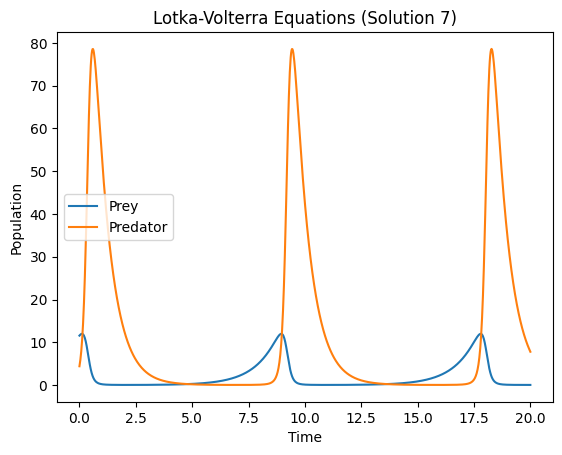

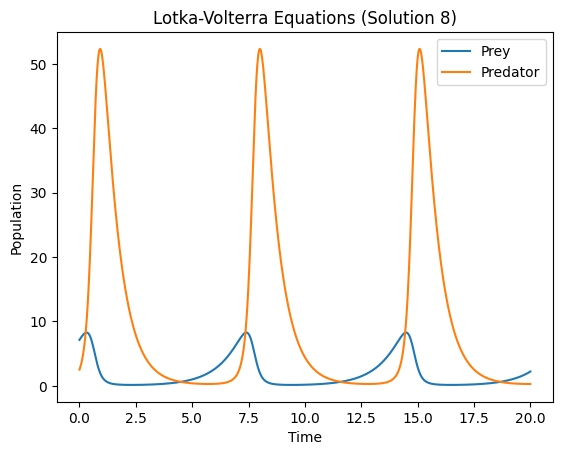

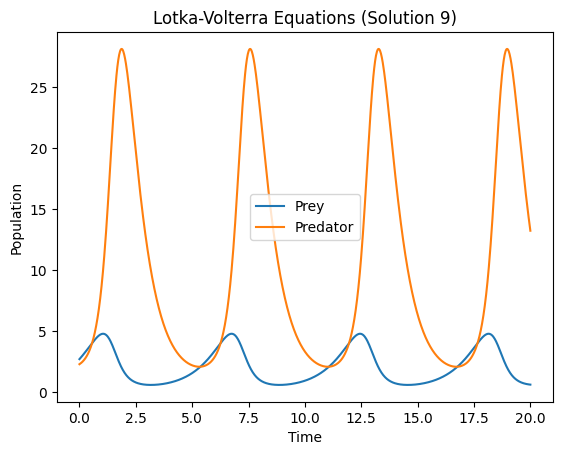

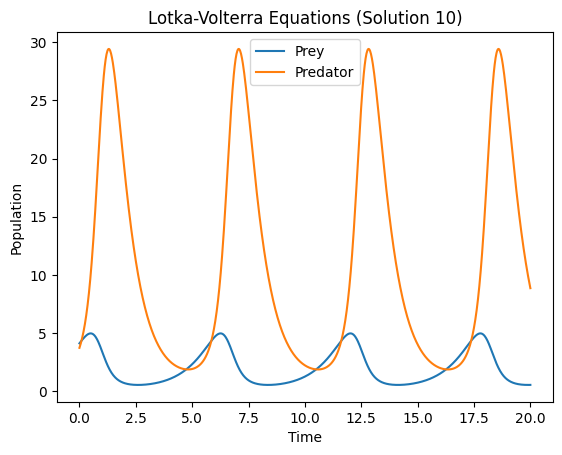

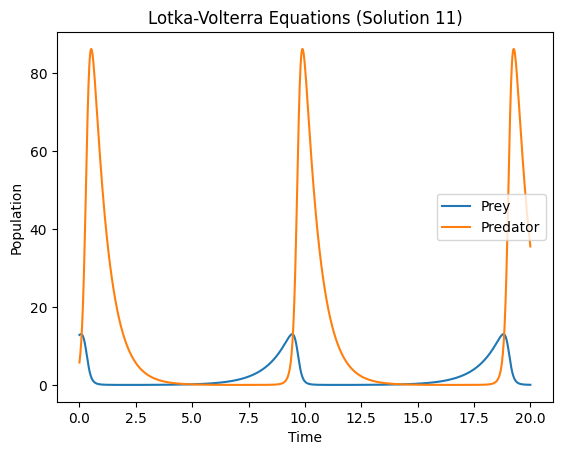

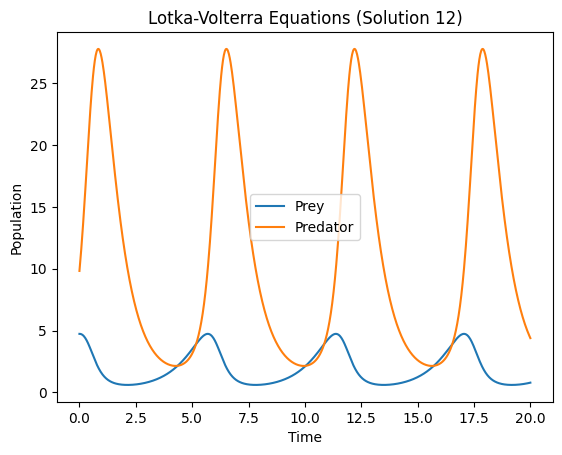

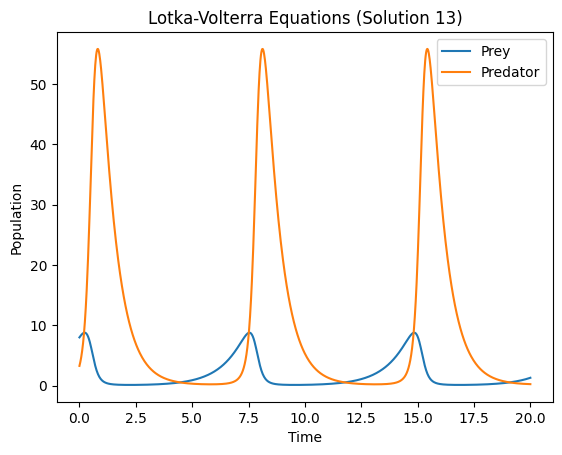

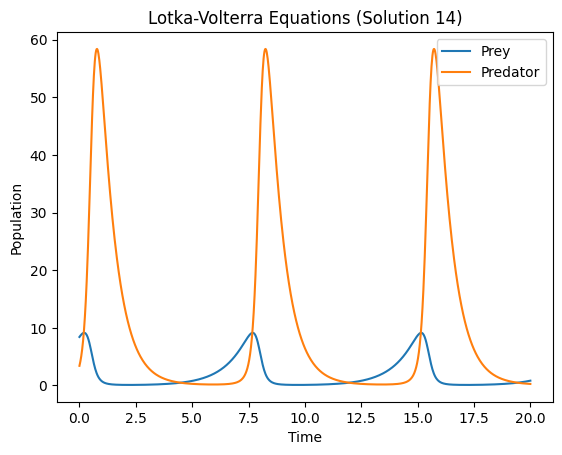

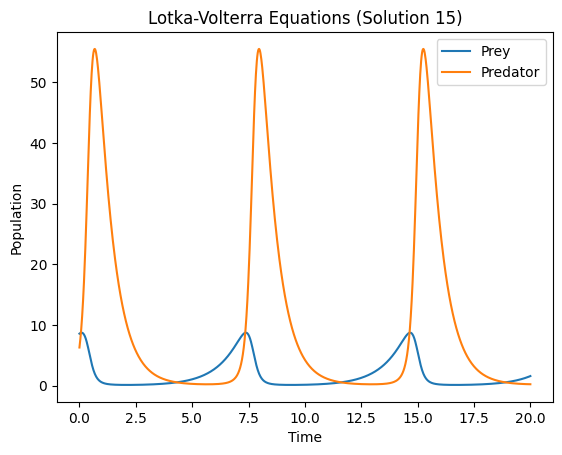

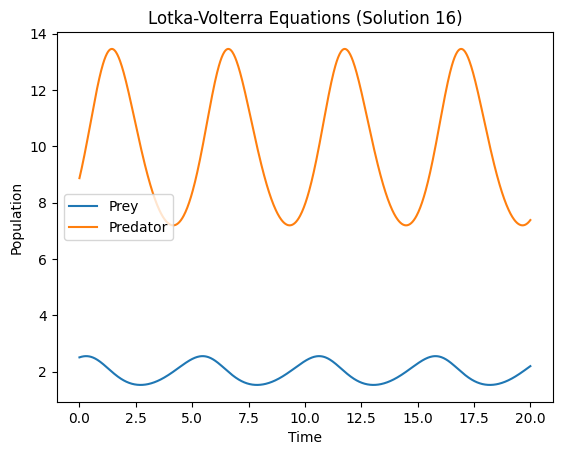

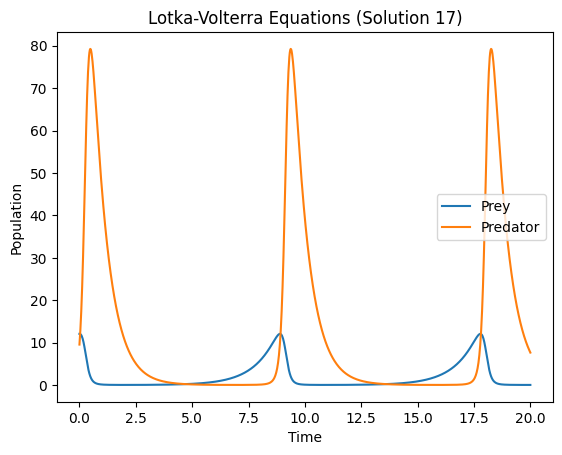

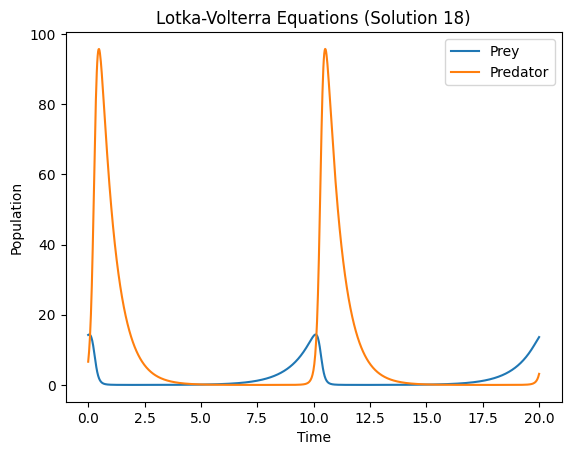

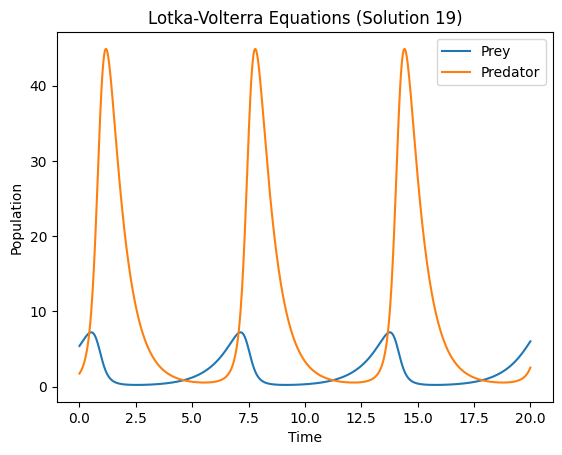

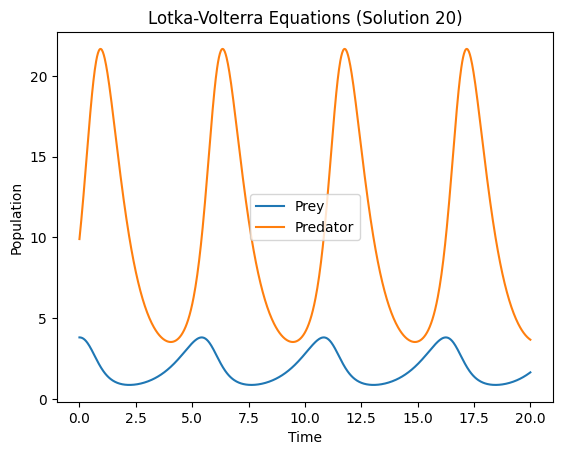

In [97]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.integrate import odeint


def lotka_volterra(state, t, alpha, beta, gamma, delta):
  """Lotka-Volterra equations."""
  x, y = state  # Unpack the state vector
  dxdt = alpha * x - beta * x * y
  dydt = delta * x * y - gamma * y
  return [dxdt, dydt]

# Parameters
alpha = 1.0
beta = 0.1
gamma = 1.5
delta = 0.75

# Time points
t = np.linspace(0, 20, 1000)

# Generate 20 solutions with random initial conditions
solutionList = []
num_solutions = 20
for i in range(num_solutions):
  # Random initial conditions
  x0 = np.random.uniform(1, 20)
  y0 = np.random.uniform(1, 10)

  # Solve the ODE
  solution = odeint(lotka_volterra, [x0, y0], t, args=(alpha, beta, gamma, delta))
  solutionList.append(solution)

  # Extract the results
  x_population = solution[:, 0]
  y_population = solution[:, 1]

  # Plot the results
  plt.plot(t, x_population, label='Prey')
  plt.plot(t, y_population, label='Predator')
  plt.xlabel('Time')
  plt.ylabel('Population')
  plt.title(f'Lotka-Volterra Equations (Solution {i+1})')
  plt.legend()
  plt.show()

In [98]:
# use finite differences to calculate derivative of solutionList
def calculate_derivative_fd(solution, t):
  dxdt = np.diff(solution, axis=0) / np.diff(t)
  return dxdt


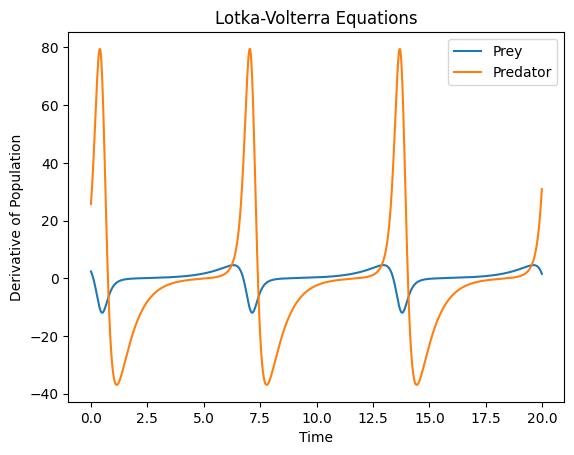

In [99]:
plt.plot(t[:-1], calculate_derivative_fd(solutionList[0][:, 0],t), label='Prey')
plt.plot(t[:-1], calculate_derivative_fd(solutionList[0][:, 1],t), label='Predator')
plt.xlabel('Time')
plt.ylabel('Derivative of Population')
plt.title('Lotka-Volterra Equations')
plt.legend()
plt.show()


In [115]:
from torch import nn
from torch import optim
import torch

class PredatorPreyModel(nn.Module):
    def __init__(self):
        super(PredatorPreyModel, self).__init__()
        # Define whatever model parameters you want to add.
        # Don't forget to set 'requires_grad=True' for trainable parameters
        self.params = nn.parameter.Parameter(torch.tensor([1.0,1.0,1.0,1.0], requires_grad=True))
        # self.params = nn.parameter.Parameter(torch.tensor([1.0,0.1,-1.5,0.75], requires_grad=True))



    def forward(self, x):
        u = x.index_select(-1,torch.tensor(0))
        v = x.index_select(-1,torch.tensor(1))

        xdot =  self.params[0]*u - self.params[1]*u*v
        ydot = -self.params[2]*v + self.params[3]*u*v

        return torch.concatenate([xdot,ydot],dim=-1)



In [116]:
# calculate derivatives
x_torch = torch.tensor(np.array(solutionList))
dt = t[1] - t[0]
dxdt_torch = torch.diff(x_torch,axis=1)/dt

#throw away last point to make dxdt the same size as x
x_torch = x_torch[:,:-1,:]

In [117]:
x_torch.shape
x_torch.index_select(-1,torch.tensor(0)).shape

torch.Size([20, 999, 1])

In [118]:
model = PredatorPreyModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    modeloutput = model(x_torch)
    loss = torch.mean((modeloutput-dxdt_torch)**2)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print('Epoch {}, Loss {}'.format(epoch, loss.item()), model.params.detach().numpy())

Epoch 0, Loss 1678.7881053662302 [1.001 0.999 1.001 0.999]
Epoch 1000, Loss 58.66188830270271 [1.6735482  0.29905617 1.423972   0.7226339 ]
Epoch 2000, Loss 3.0363225198769195 [1.7158645  0.13240193 1.5164155  0.74594194]
Epoch 3000, Loss 2.13179636841506 [1.5292743  0.11886711 1.5281669  0.74892056]
Epoch 4000, Loss 1.5168778365661792 [1.311327   0.11132567 1.5283909  0.74897724]
Epoch 5000, Loss 1.2269816052022167 [1.1230643  0.10484698 1.528394   0.74897814]
Epoch 6000, Loss 1.1609964418656196 [1.0125521  0.10105056 1.5283961  0.74897873]
Epoch 7000, Loss 1.1561835555820885 [0.97755873 0.09984904 1.5283972  0.74897903]
Epoch 8000, Loss 1.1561266350689707 [0.9734232  0.09970707 1.528398   0.7489793 ]
Epoch 9000, Loss 1.1561266017500118 [0.9733251 0.0997037 1.5283984 0.7489794]


In [119]:
from scipy.integrate import odeint
fitModelList = []
def rhs_func(y, t, model):
    with torch.no_grad():  # Disable gradient calculations for odeint
        return model(torch.tensor(y)).detach().numpy()  # Assuming model outputs a PyTorch tensor


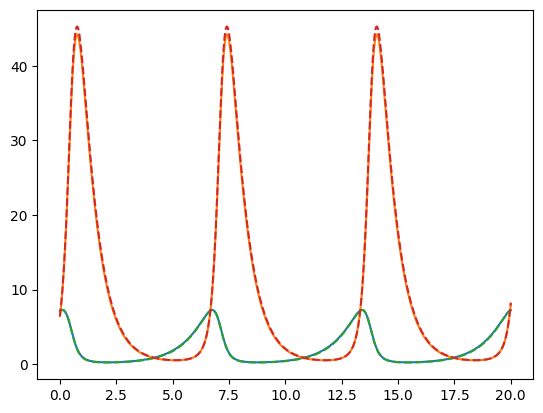

In [120]:
dataIndex = 0
fitModel = odeint(rhs_func, x_torch[dataIndex][0], t, args=(model,))
plt.plot(t, fitModel[:,0], label='Prey')
plt.plot(t, fitModel[:,1], label='Predator')
plt.plot(t, solutionList[dataIndex][:,0], '--', label='Prey truth')
plt.plot(t, solutionList[dataIndex][:,1], '--', label='Predator truth')